In [48]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import seaborn

# Accuracies

In [20]:
accuracies = list(pathlib.Path(".").glob("*accuracy.npy"))
acc_names = [x.name.split("_")[0].title() for x in accuracies]
accuracies = [np.load(x) for x in accuracies]
acc_names

['Lava', 'Snntorch', 'S2', 'Norse']

In [21]:
acc_df = pd.DataFrame(accuracies, index=acc_names, columns=["Accuracy"]).T.sort_index()
acc_df

,Lava,Snntorch,S2,Norse
Accuracy,0.981507,0.979035,0.982,0.9811


In [22]:
print(acc_df.to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
 & Lava & Snntorch & S2 & Norse \\
\midrule
Accuracy & 0.982 & 0.979 & 0.982 & 0.981 \\
\bottomrule
\end{tabular}



# Confusion matrix

In [42]:
def format_name(x):
    return " ".join(x.split("_")[:-1]).replace(" corrected", "").title().replace("Snntorch", "snnTorch")
activities = [str(x.name) for x in pathlib.Path(".").glob("*activity.npy")]
activities.remove("s2_brian2_uncorrected_activity.npy")
activities.remove("s2_uncorrected_activity.npy")
activities.sort()
names = [format_name(x) for x in activities]
activities = [np.load(str(p)) for p in activities]
names

['Lava', 'Norse', 'S2 Brian2', 'S2', 'snnTorch']

In [43]:
activities[-2][:-1].shape

(299, 10, 16, 16, 16)

In [44]:
metric = torch.nn.CosineSimilarity(0)
divs = pd.DataFrame(index=names).sort_index()
for i in range(len(activities)):
  act_row = []
  for i_col in range(len(activities)):
    a1 = torch.tensor(activities[i]).float().mean(0).flatten(0)
    a2 = torch.tensor(activities[i_col]).float().mean(0).flatten(0) 
    dist = metric(a1, a2)
    act_row.append(dist.item())
  divs[names[i]] = act_row
divs

,Lava,Norse,S2 Brian2,S2,snnTorch
Lava,1.000000,1.000000,0.997176,0.997176,0.785451
Norse,1.000000,1.000000,0.997176,0.997176,0.785451
S2,0.997176,0.997176,0.999999,0.999999,0.785845
S2 Brian2,0.997176,0.997176,0.999999,0.999999,0.785845
snnTorch,0.785451,0.785451,0.785845,0.785845,1.000002


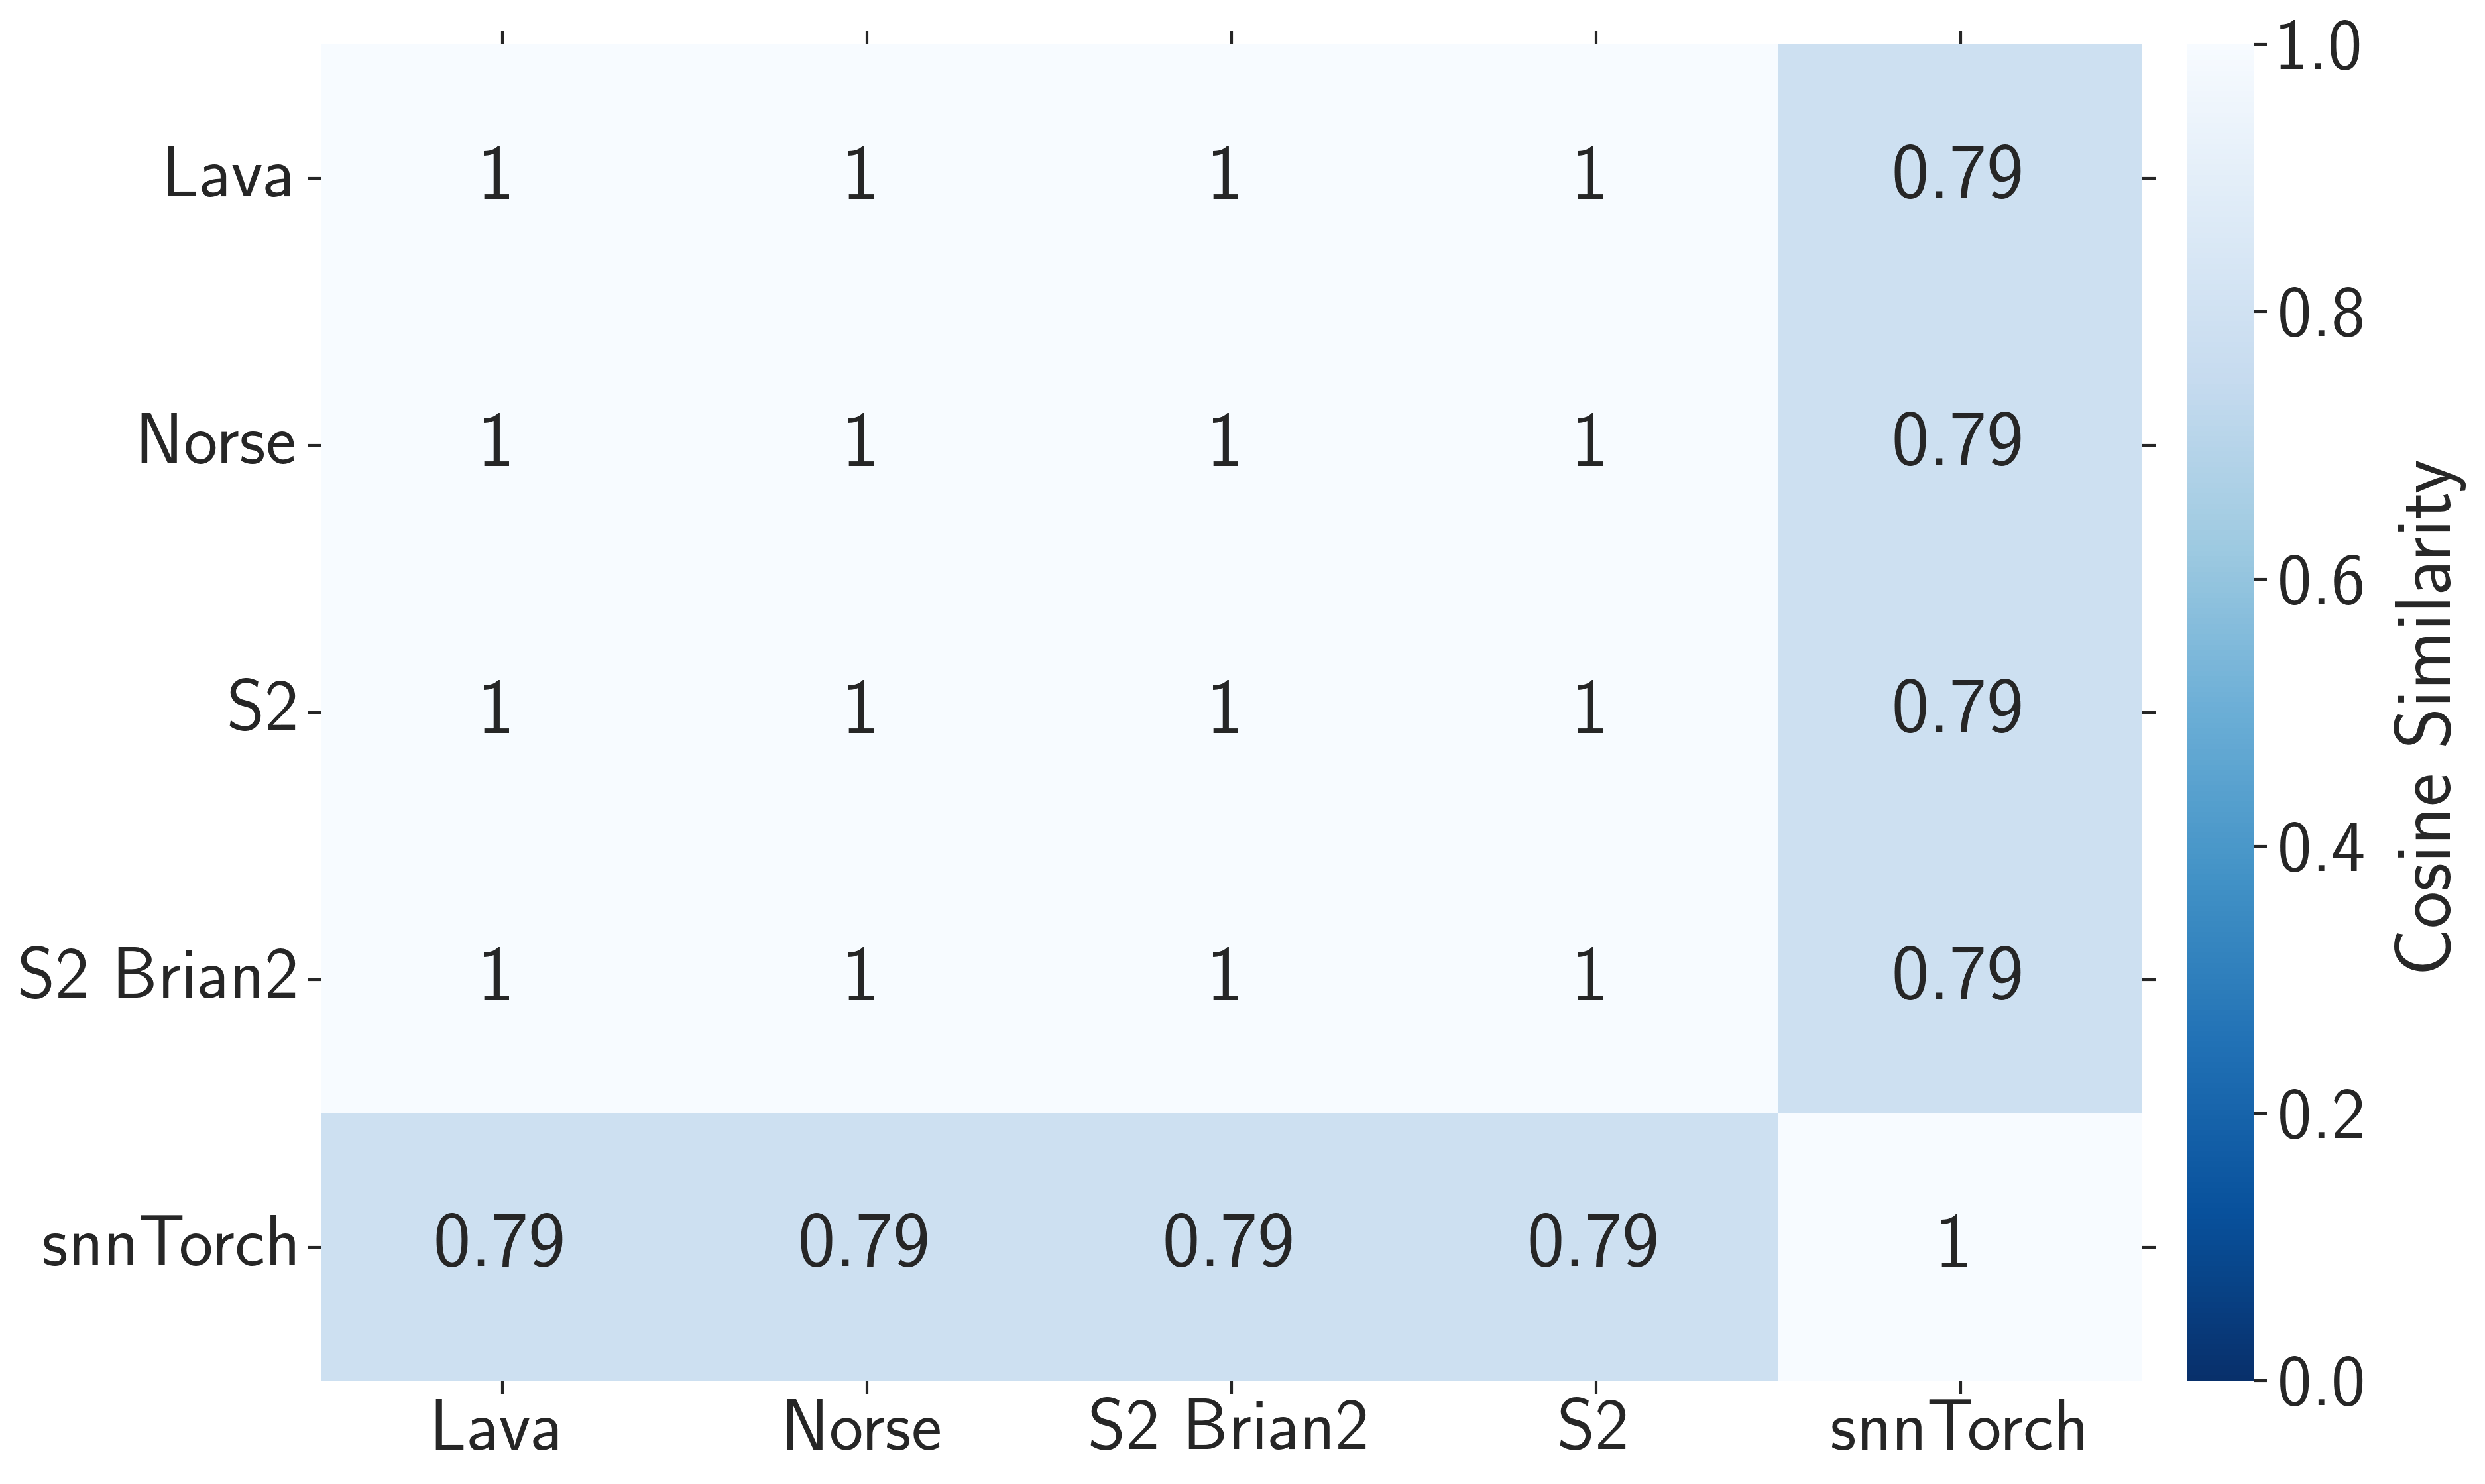

In [52]:
plt.style.use("../plots.mplstyle")
seaborn.set_context("paper", font_scale=3)
seaborn.set_style("whitegrid")

f, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
seaborn.heatmap(divs.abs(), ax=ax, cmap="Blues_r", cbar_kws={"pad": 0.02}, annot=True, vmin=0)
ax.collections[0].colorbar.set_label("Cosine Similarity", labelpad=10)
# ax.collections[0].colorbar.ax.yaxis.set_ticks_position("left")
ax.collections[0].colorbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
ax.collections[0].colorbar.ax.tick_params(pad=5)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
f.savefig("../figures/conv_similarity.pdf", bbox_inches="tight")

# Plot digit input

In [88]:
c = plt.colormaps.get("Blues")
c(1)

(0.9655517108804306, 0.9823452518262207, 0.9990157631680123, 1.0)

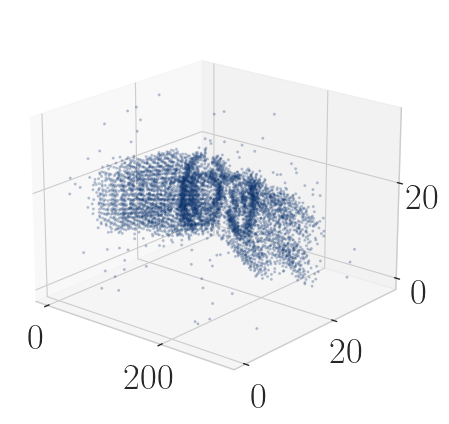

In [146]:
frames = np.load("val_numbers.npy")[:,8].sum(1)
coords = torch.tensor(frames).to_sparse().indices()
ax = plt.subplot(projection="3d")
ax.view_init(azim=310, elev=20)
ax.scatter(*coords, s=2, alpha=0.2, color=c(1.))

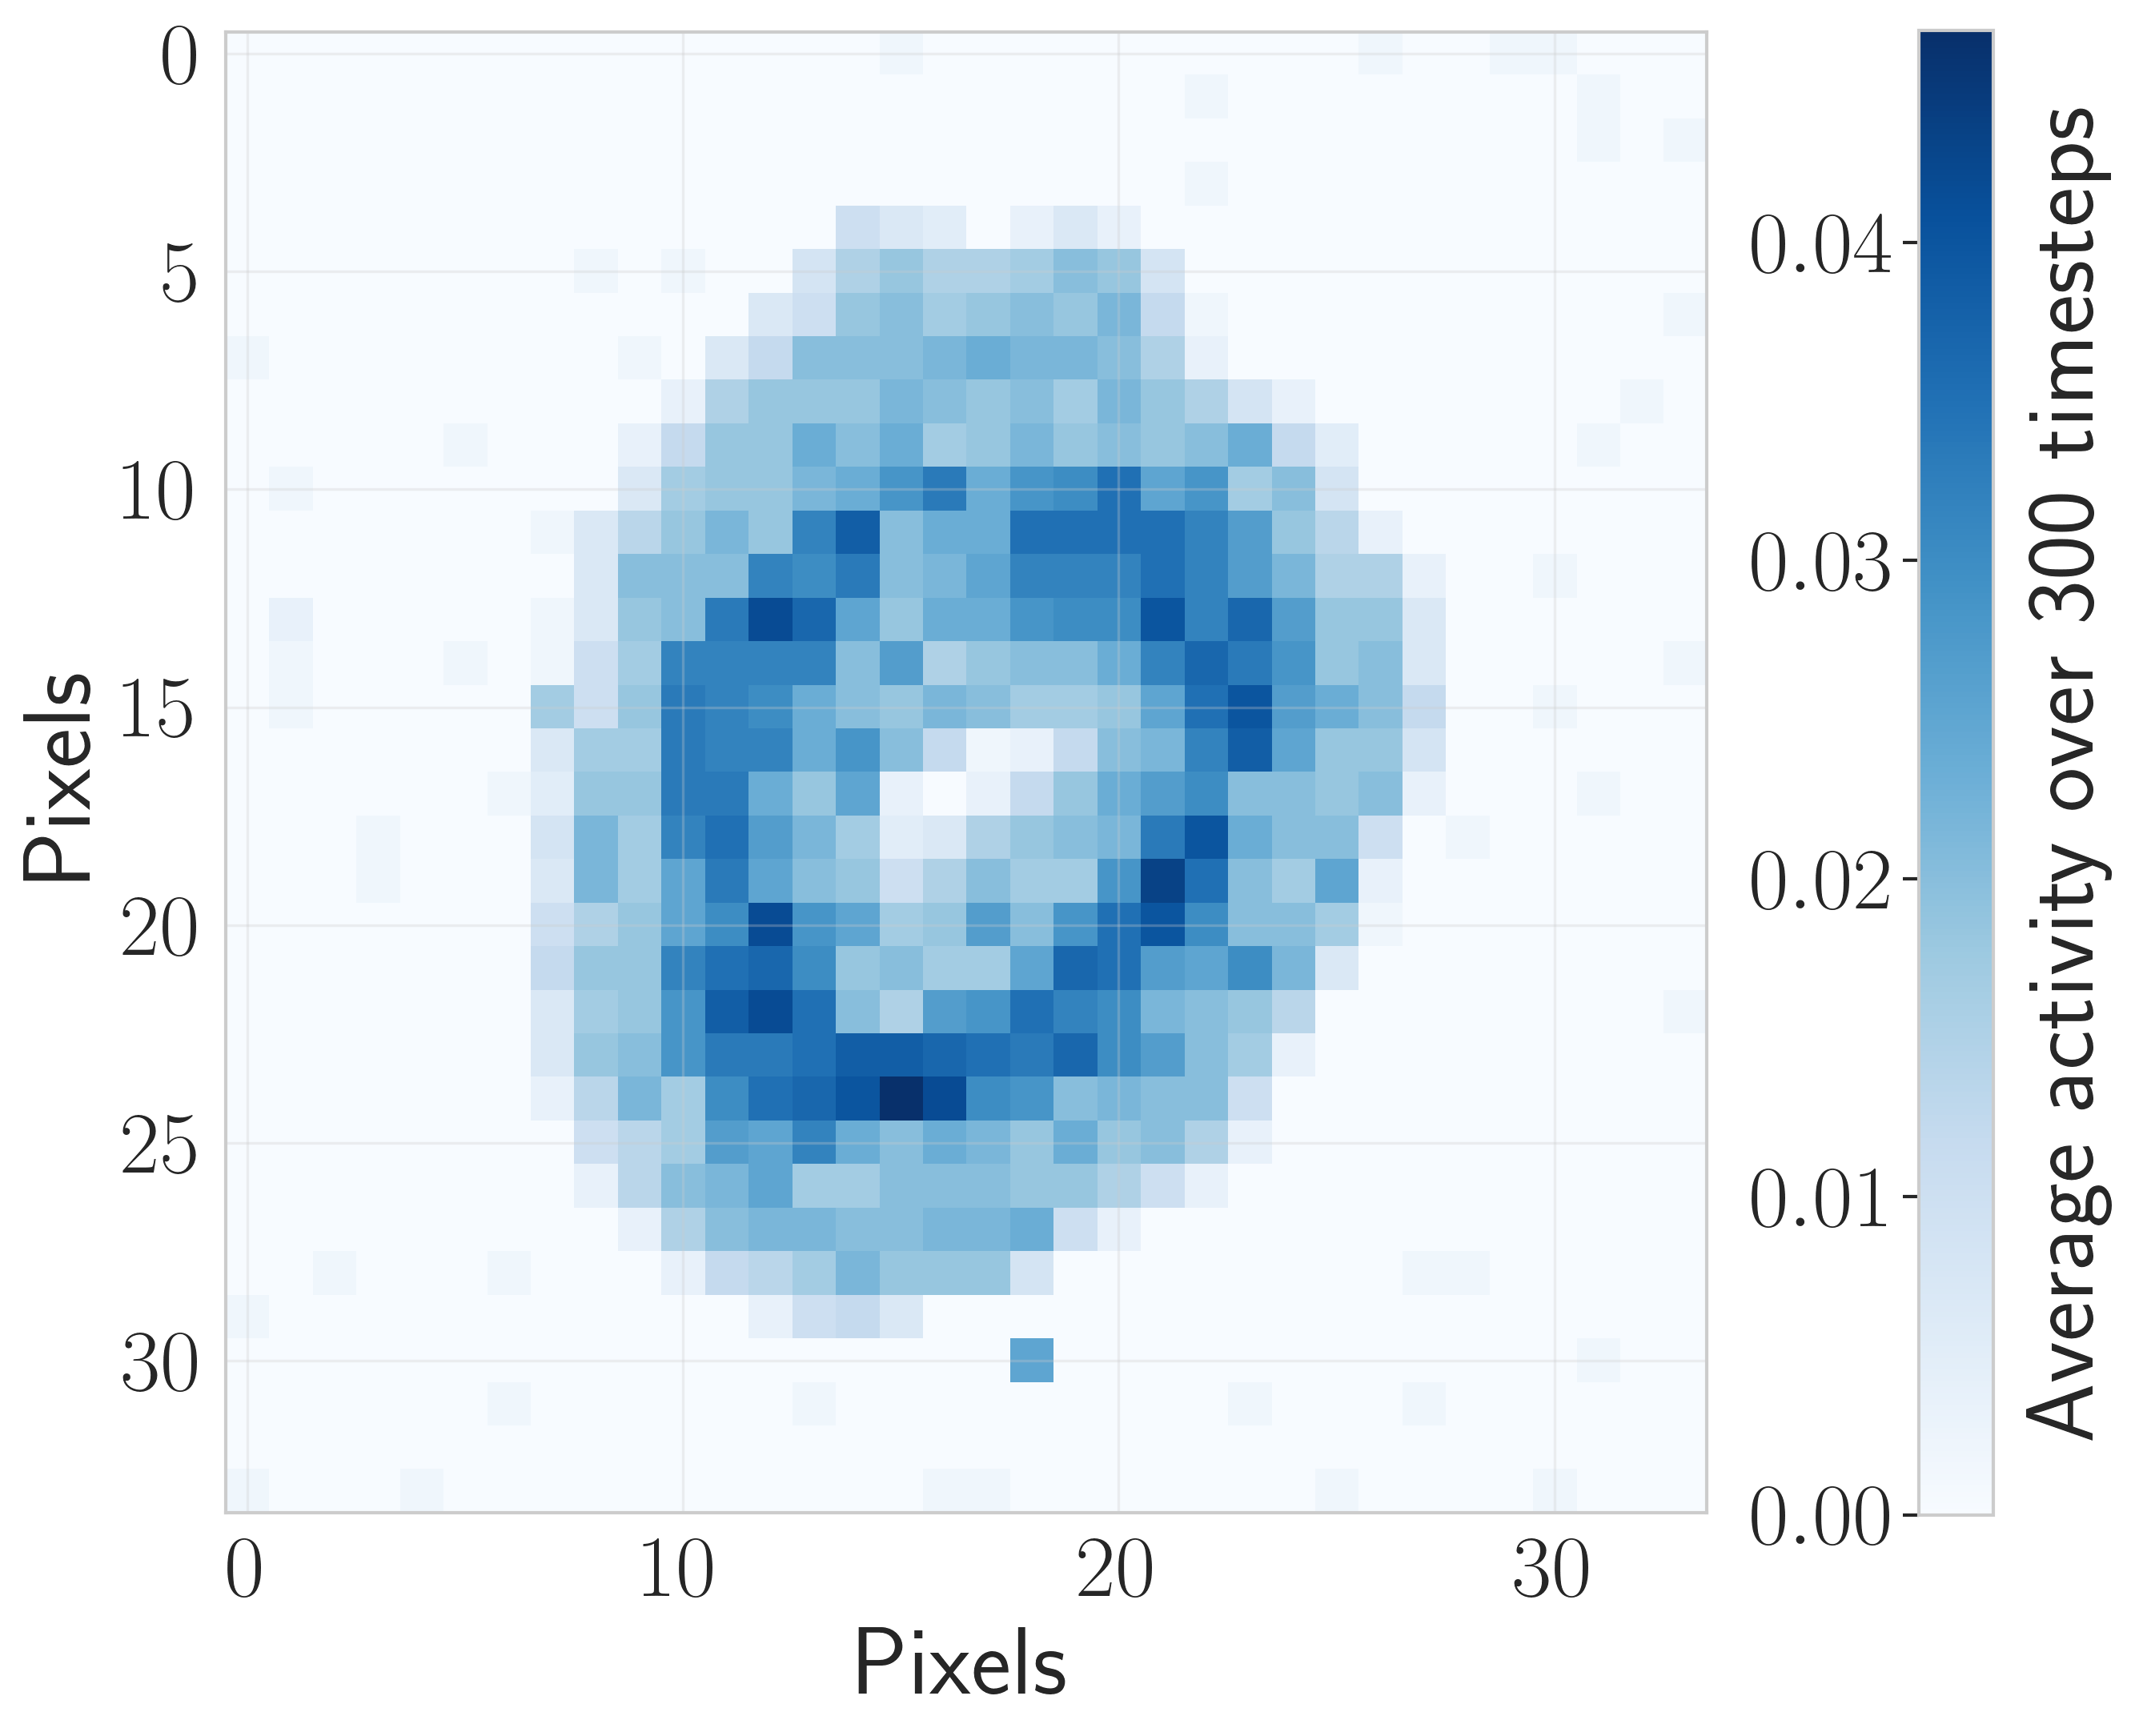

In [339]:
f, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
cax = ax.imshow(np.load("val_numbers.npy").mean(0)[0].mean(0), cmap="Blues")
cbar = f.colorbar(cax, fraction=0.042, pad=0.12)
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_label("Average activity over 300 timesteps", labelpad=10)
ax.set_xlabel("Pixels")
ax.set_ylabel("Pixels")
f.savefig("../figures/nmnist_zero.pdf", bbox_inches="tight")